# Quantum Building Blocks
<hr></hr>

In order to understand some of the most relevant quantum protocols and algorithms, we must first introduce a few very important and prevalent quantum circuits, which serve as building blocks in the more advanced quantum routines. These include primitives such as: the preparation of important types of entangled states, namely [Bell states](https://en.wikipedia.org/wiki/Bell_state), [GHZ states](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state), and [W states](https://en.wikipedia.org/wiki/Hadamard_transform#Hadamard_transform_in_quantum_algorithms); the [Quantum Hadamard transform](https://en.wikipedia.org/wiki/Hadamard_transform); and [Phase kickback](https://en.wikipedia.org/wiki/Phase_kickback). 

We will also discuss some interesting routines such as the [Hadamard test](https://en.wikipedia.org/wiki/Hadamard_test) and the [Swap test](https://en.wikipedia.org/wiki/Swap_test), which relate to the computation of certain system properties in the form of the expectation values (i.e., averages) of repeated measurements. 

Other more advanced primitives, like the [Quantum Fourier Transform](https://en.wikipedia.org/wiki/Quantum_Fourier_transform), will be discussed in a separate chapter since they are more involved, requiring a longer description.

## 1. Preparation of (Some) Entangled States

### 1.1 Bell States

The Bell states correspond to an important set of 2-qubit entangled states utilized in many quantum protocols such as [quantum teleportation](https://en.wikipedia.org/wiki/Quantum_teleportation) and [superdense coding](https://en.wikipedia.org/wiki/Superdense_coding). 

There are four Bell states, which correspond to equal superposition statevectors that, in the computational basis $\{|0\rangle, |1\rangle\}^{\otimes 2}$, are given by:

$$
\begin{aligned}
|\Phi^+ \rangle = \frac{1}{\sqrt{2}}\left(|00\rangle + |11\rangle \right), \quad \quad 
|\Phi^- \rangle = \frac{1}{\sqrt{2}}\left(|00\rangle - |11\rangle \right), 
\\
\\
|\Psi^+ \rangle = \frac{1}{\sqrt{2}}\left(|01\rangle + |10\rangle \right), \quad \quad 
|\Psi^- \rangle = \frac{1}{\sqrt{2}}\left(|01\rangle - |10\rangle \right).
\end{aligned}
$$

These states can be generated by taking the four computational basis states $|00\rangle, |01\rangle, |10\rangle, |11\rangle $, and evolving them through the following quantum circuit:

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

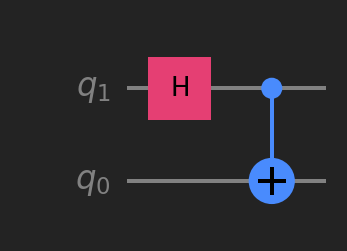

In [2]:
qc = QuantumCircuit(2)
qc.h(1)
qc.cx(1,0)
qc.draw()

We can see the correspondence between each computational basis state, and the respective Bell state below:

In [3]:
q00 = Statevector.from_label('00') # Comp. basis state |00⟩
q01 = Statevector.from_label('01') # Comp. basis state |01⟩
q10 = Statevector.from_label('10') # Comp. basis state |10⟩
q11 = Statevector.from_label('11') # Comp. basis state |11⟩

Φp = q00.evolve(qc)                # Bell basis state |Φ⁺⟩
Ψp = q01.evolve(qc)                # Bell basis state |Ψ⁺⟩
Φm = q10.evolve(qc)                # Bell basis state |Φ⁻⟩
Ψm = q11.evolve(qc)                # Bell basis state |Ψ⁻⟩

In [4]:
print(f'state |00⟩ evolves to state: ')
display(Φp.draw('latex',prefix='|\\Phi^+ \\rangle = '))

print(f'state |01⟩ evolves to state: ')
display(Ψp.draw('latex',prefix='|\\Psi^+ \\rangle = '))

print(f'state |10⟩ evolves to state: ')
display(Φm.draw('latex',prefix='|\\Phi^- \\rangle = '))

print(f'state |11⟩ evolves to state: ')
display(Ψm.draw('latex',prefix='|\\Psi^- \\rangle = '))

state |00⟩ evolves to state: 


<IPython.core.display.Latex object>

state |01⟩ evolves to state: 


<IPython.core.display.Latex object>

state |10⟩ evolves to state: 


<IPython.core.display.Latex object>

state |11⟩ evolves to state: 


<IPython.core.display.Latex object>

### 1.2 GHZ States

Greenberger–Horne–Zeilinger (GHZ) states are a generalization of the $|\Phi^+ \rangle$ Bell state, but for 3 or more qubits. For example, for the specific case of 3 qubits, this state is given by:

$$ |\Omega\rangle = \frac{1}{\sqrt{2}}\left(|000\rangle + |111\rangle \right) ,$$

but it can be generalized for $n$ qubits, but creating an equal superposition of the all-zeros and all-ones state:

$$ |\Omega_n\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle^{\otimes n} + |1\rangle^{\otimes n} \right) .$$


There are several ways in which these states can be created using a quantum circuits. The simplest, and perhaps most intuitive, way is by placing one of the qubits in equal superposition, and then entangling the remaining qubits (initialized at $|0\rangle$) by using $CX$ gates as follows:

In [5]:
def ghz_cir_a(n):
    # create quantum circuit with n qubits
    qc_ghz = QuantumCircuit(n)
    
    # place most significant qubit in equal superposition
    qc_ghz.h(n-1)
    
    # apply cx gates between superposition qubit and remaning qubits
    for i in reversed(range(n-1)):
        qc_ghz.cx(n-1,i)
        
    return qc_ghz

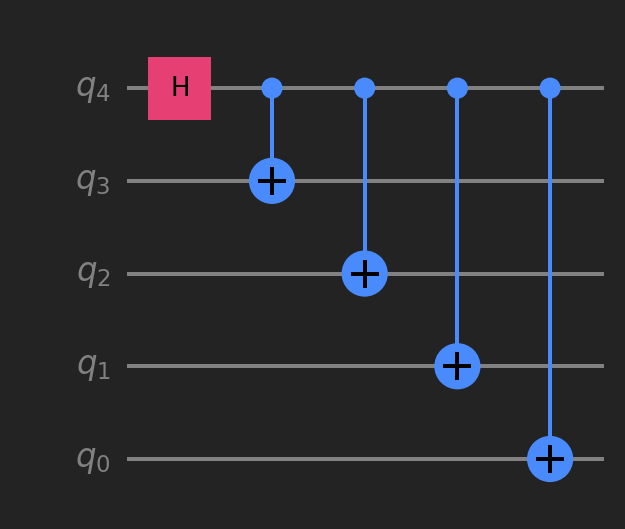

<IPython.core.display.Latex object>

In [6]:
# Create GHZ circuit for n qubits
n = 5
qc = ghz_cir_a(n)
display(qc.draw())

# Display 5-qubit GHZ state
Statevector(qc).draw('latex', prefix=f'|\\Omega _{n}\\rangle = ')

One of the issues with this circuit is that, in many quantum hardware architectures, not all qubits are physically connected to each other. Therefore, applying the $CX$ gates between non-adjacent qubits is not possible. For example, if a quantum chip only allows for "nearest neighbor" connectivity, qubit $q_4$ in the circuit below would only be directly connected to $q_3$, so it will require adding extra $\text{SWAP}$ gates to allow the entanglement between the remaining qubits. And of course, these extra gates add noise, which is not desirable. Alternatively, GHZ states can also be generated by gradually entangling each successive pair of qubits:

In [7]:
def ghz_cir_b(n):
    # create quantum circuit with n qubits
    qc_ghz = QuantumCircuit(n)
    
    # place most significant qubit in equal superposition
    qc_ghz.h(n-1)
    
    # apply cx gates between successive pairs of qubits
    for i in reversed(range(n-1)):
        qc_ghz.cx(i+1,i)
        
    return qc_ghz

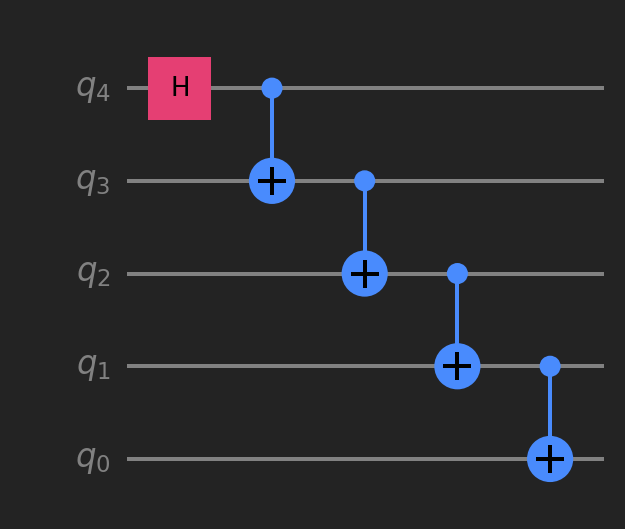

<IPython.core.display.Latex object>

In [8]:
# Create GHZ circuit for n qubits
n = 5
qc = ghz_cir_b(n)
display(qc.draw())

# Display 5-qubit GHZ state
Statevector(qc).draw('latex', prefix=f'|\\Omega _{n}\\rangle = ')

Now, the problem with this approach is that, since each $CX$ gate needs to be applied sequentially, the total circuit depth for $n$ qubits is equal to $n+1$. In other words, no $CX$ gates are being applied in parallel. This is problematic when the number of qubits is large because, the most significant qubits are being left idle for a long period of time, which leads to errors in the computation. 

It is therefore desirable to implement GHZ circuits where the nearest-neighbor connectivity is preserved, but the depth of the circuit is reduced. The example below cuts the depth to $n/2 + 2$, but there are more clever techniques where, for certain connectivity maps, the total number of $CX$ gates can be reduced to be order $\log_2(n)$.

In [9]:
def ghz_cir_c(n):
    # create quantum circuit with n qubits
    qb_mid = n//2
    qc_ghz = QuantumCircuit(n)
    
    # place most significant qubit in equal superposition
    qc_ghz.h(qb_mid)
    
    # apply cx gates between successive pairs of qubits
    for i in reversed(range(qb_mid)):
        qc_ghz.cx(i+1,i)
    
    for i in range(qb_mid,n-1):
        qc_ghz.cx(i,i+1)
    
    return qc_ghz

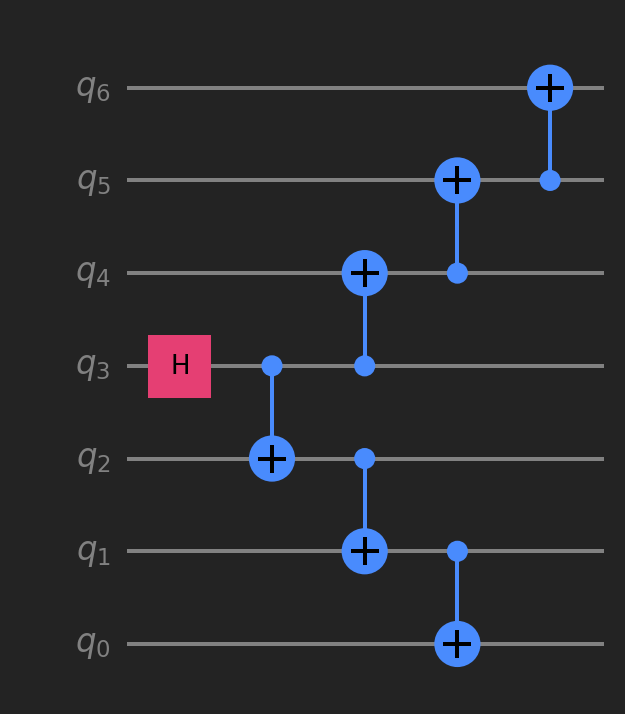

<IPython.core.display.Latex object>

In [10]:
# Create GHZ circuit for n qubits
n = 7
qc = ghz_cir_c(n)
display(qc.draw())

# Display 5-qubit GHZ state
Statevector(qc).draw('latex', prefix=f'|\\Omega _{n}\\rangle = ')

### 1.3 W States

Just like GHZ states can be seen as a generalization of the $|\Phi^+\rangle$ Bell state, W states can be considered to be a generalization of the $|\Psi^+\rangle$ Bell state for 3 or more qubits. So, for the particular case of 3 qubits we have:

$$ |\text{W}\rangle = \frac{1}{\sqrt{3}}\left(|001\rangle + |010\rangle + |100\rangle \right) .$$

But in general, for $n$ qubits:

$$ |\text{W}_n\rangle = \frac{1}{\sqrt{n}}\sum_{j=0}^{n-1} |2^j\rangle ,$$

where we use the integer $2^j$ inside the ket to denote the binary value for that number. So, for example, for $n = 5$, we have:

$$ 
\begin{aligned}
|\text{W}_5\rangle &= \frac{1}{\sqrt{5}}\left(|1\rangle + |2\rangle + |4\rangle + |8\rangle + |16\rangle \right) 
\\
\\
|\text{W}_5\rangle &= \frac{1}{\sqrt{5}}\left(|00001\rangle + |00010\rangle + |00100\rangle + |01000\rangle + |10000\rangle \right) 
\end{aligned}
$$

The circuit to generate these states is more involved than that of GHZ states, but below is the step-by-step procedure to follow. Furthermore, I provide a detailed description of why these steps work in this [post](https://nbviewer.org/github/diemilio/quantum-playground/blob/main/w-states/w-states.ipynb). 

1. Initialize state to the all-zeros state: $|0\rangle^{\otimes n}$

2. Compute the probability amplitude $w$ of the final superposition state: $\sqrt{\frac{1}{n}} $

3. Calculate an angle of rotation $\theta_{n-1}$ as:
    $$ \theta_{n-1} = 2 \cos^{\text{-}1} \left ( \sqrt{\frac{1}{n}} \right )  $$
    
4. Apply an $y$-rotation gate $R_y(\theta_{n-1})$ on $q_{n-1}$ such that we get the superposition state:

    $$ \sqrt{\frac{1}{n}} | 00 \dots 00 \rangle + \sqrt{1 - \frac{1}{n}} | 10 \dots 00 \rangle $$
    

5. For $k = n - 1$, to $k = 0$:
     - Compute the complementary probability amplitude $\bar w_{k-1}$ as:

        $$ \bar w_{k-1} = \sqrt{\frac{k}{n}} $$


    - Calculate the angle $\theta_{k-1}$:

        $$ 
        \theta_{k} = 2 \cos^{\text{-}1} \left ( \frac{w}{\bar w} \right ) = 2 \cos^{\text{-}1} \left ( \sqrt{\frac{1}{k}} \right ) 
        $$


    - Perform a controlled y-rotation ($CR_y(\theta_{k-1})$ gate) with $q_{k}$ as control and $q_{k-1}$ as target, such that we generate the entangled state:

        $$ 
        \sqrt{\frac{1}{n}} | 00 \dots 00 \rangle + \sqrt{\frac{1}{n}} | 10 \dots 00 \rangle + \dots + \sqrt{1 - \frac{k}{n}} | 11 \dots 10 \rangle
        $$


6. For $k = 1$, to $k = n-1$, Apply a $CX$ gate with $q_{k}$ as the control and $q_{k-1}$ as the target, such that we end up with the state:

    $$
    \frac{1}{\sqrt{n}} \left ( | 00 \dots 00 \rangle + | 10 \dots 01 \rangle + \dots + | 11 \dots 00 \rangle \right ) 
    $$
    
7. Apply an $X$ gate on $q_{n-1}$ so we get the desired state:

    $$
    \frac{1}{\sqrt{n}} \left ( | 00 \dots 01 \rangle + | 0\dots 10 \rangle + \dots + | 10 \dots 00 \rangle \right ) .
    $$
    
To understand this better, here is a function that generates a W state for $n$ qubits:

In [11]:
def w_cir_a(n):
    
    prob_amp = np.sqrt(1/n)
    rot_ang = 2*np.arccos(prob_amp)
    
    qc_w = QuantumCircuit(n) 
    
    # probability redistribution
    qc_w.ry(rot_ang,n-1)
    
    for k in range(n-1,1,-1):
        comp_amp = np.sqrt(k/n)
        rot_ang = 2*np.arccos(prob_amp/(comp_amp))
        qc_w.cry(rot_ang,k,k-1)
    
    # state reshuffling
    for k in range(1, n):
        qc_w.cx(k,k-1)
    
    qc_w.x(n-1)
    
    return qc_w

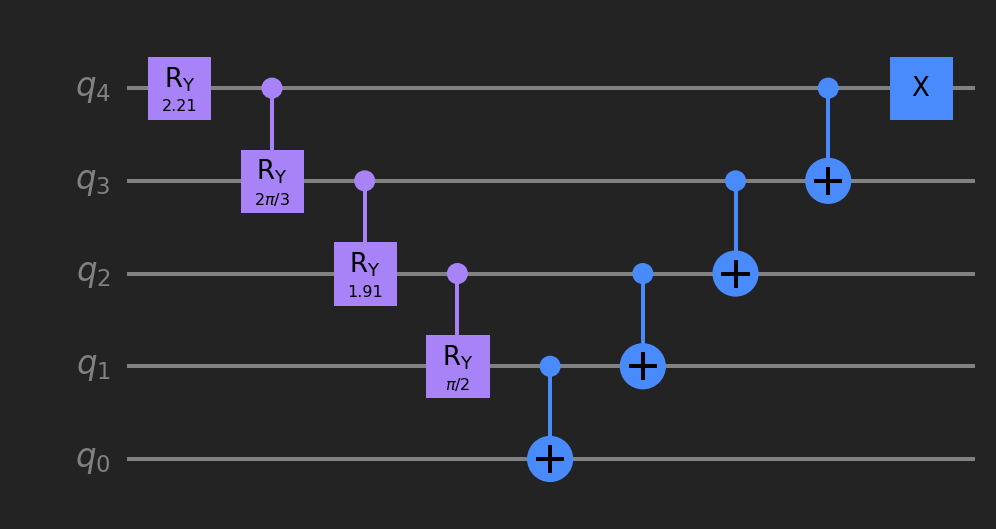

<IPython.core.display.Latex object>

In [12]:
n = 5
qc = w_cir(n)
display(qc.draw())

# Display 5-qubit GHZ state
Statevector(qc).draw('latex', prefix=f'|\\text W_{n} \\rangle = ')

Similar to the GHZ circuits, there are also a methods to generate W states with circuit lower depths. [[Cruz18]](https://arxiv.org/pdf/1807.05572) provides some insight into how both GHZ and W state generation can be accomplished using circuits with number of gates in order $\log_2(n)$.

## 2. The Quantum Hadamard Transform

